# Import Packages

In [1]:
import numpy as np
import pandas as pd

from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer

from jcopml.pipeline import num_pipe, cat_pipe
from jcopml.utils import save_model, load_model
from jcopml.plot import plot_missing_value
from jcopml.feature_importance import mean_score_decrease

# Import Data

In [2]:
df = pd.read_csv("data/Admission_Predict_Ver1.1.csv", index_col="Serial No.")
df.head()

,GRE Score,TOEFL Score,University Rating,SOP,LOR,CGPA,Research,Chance of Admit
Serial No.,,,,,,,,
1,337,118,4,4.5,4.5,9.65,1,0.92
2,324,107,4,4.0,4.5,8.87,1,0.76
3,316,104,3,3.0,3.5,8.00,1,0.72
4,322,110,3,3.5,2.5,8.67,1,0.80
5,314,103,2,2.0,3.0,8.21,0,0.65


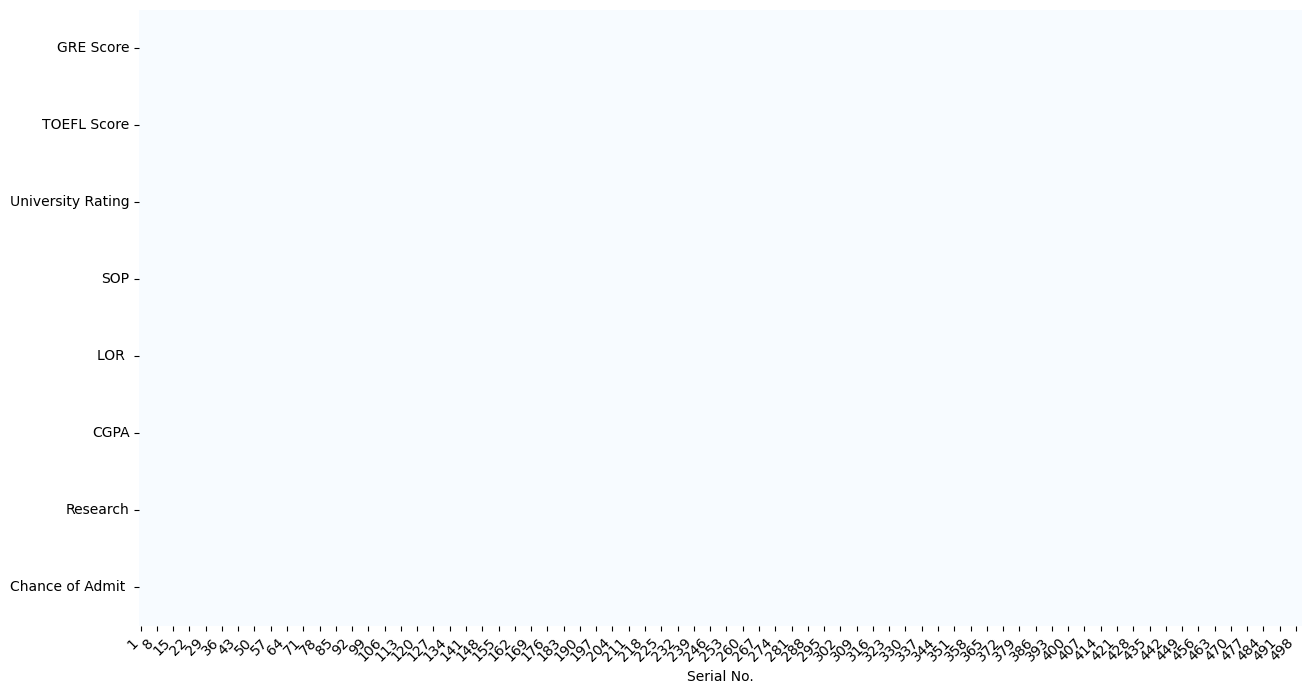

In [3]:
plot_missing_value(df)

# Dataset Splitting

In [4]:
df.columns

Index(['GRE Score', 'TOEFL Score', 'University Rating', 'SOP', 'LOR ', 'CGPA',
       'Research', 'Chance of Admit '],
      dtype='object')

In [7]:
X = df.drop(columns="Chance of Admit ")
y = df["Chance of Admit "]
    
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((400, 7), (100, 7), (400,), (100,))

# Training

In [23]:
from xgboost import XGBRegressor
from sklearn.model_selection import RandomizedSearchCV, GridSearchCV
from jcopml.tuning import random_search_params as rsp
from jcopml.tuning import grid_search_params as gsp
from sklearn.svm import SVR

In [9]:
X_train.head()

,GRE Score,TOEFL Score,University Rating,SOP,LOR,CGPA,Research
Serial No.,,,,,,,
250,321,111,3,3.5,4.0,8.83,1
434,316,111,4,4.0,5.0,8.54,0
20,303,102,3,3.5,3.0,8.50,0
323,314,107,2,2.5,4.0,8.27,0
333,308,106,3,3.5,2.5,8.21,1


In [16]:
X_train["LOR "].value_counts()

LOR 
3.0    81
4.0    75
3.5    69
4.5    49
5.0    40
2.5    40
2.0    36
1.5    10
Name: count, dtype: int64

## XGBoost

In [19]:
preprocessor = ColumnTransformer([
    ('numeric', num_pipe(), ["GRE Score", "TOEFL Score", "CGPA"]),
    ('categoric', cat_pipe(encoder='onehot'), ["University Rating", "Research", "LOR ", "SOP"]),
])

pipeline = Pipeline([
    ('prep', preprocessor),
    ('algo', XGBRegressor(n_jobs=-1, random_state=42))
])

model = RandomizedSearchCV(pipeline, rsp.xgb_params, cv=3, n_iter=50, n_jobs=-1, verbose=1, random_state=42)
model.fit(X_train, y_train)

print(model.best_params_)
print(model.score(X_train, y_train), model.best_score_, model.score(X_test, y_test))

Fitting 3 folds for each of 50 candidates, totalling 150 fits
{'algo__colsample_bytree': 0.37079047883509275, 'algo__gamma': 1, 'algo__learning_rate': 0.989648498531856, 'algo__max_depth': 1, 'algo__n_estimators': 101, 'algo__reg_alpha': 0.10249816559563216, 'algo__reg_lambda': 0.001606626792172771, 'algo__subsample': 0.4393232321183057}
0.5092962292942816 0.5104982308516105 0.5248793619503713


C:\Users\ASUS\miniconda3\envs\jcop\Lib\site-packages\xgboost\data.py:440: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):


## SVM

In [24]:
preprocessor = ColumnTransformer([
    ('numeric', num_pipe(), ["GRE Score", "TOEFL Score", "CGPA"]),
    ('categoric', cat_pipe(encoder='onehot'), ["University Rating", "Research", "LOR ", "SOP"]),
])

pipeline = Pipeline([
    ('prep', preprocessor),
    ('algo', SVR(max_iter=500))
])

model = GridSearchCV(pipeline, gsp.svm_params, cv=3, n_jobs=-1, verbose=1)
model.fit(X_train, y_train)

print(model.best_params_)
print(model.score(X_train, y_train), model.best_score_, model.score(X_test, y_test))

Fitting 3 folds for each of 49 candidates, totalling 147 fits
{'algo__C': 10.0, 'algo__gamma': 0.001}
0.7390834519522549 0.7024252080018097 0.7477785595135465


C:\Users\ASUS\miniconda3\envs\jcop\Lib\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=500).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


## Elastic Net

In [25]:
from sklearn.linear_model import ElasticNet
from sklearn.model_selection import RandomizedSearchCV
from jcopml.tuning import random_search_params as rsp

In [26]:
preprocessor = ColumnTransformer([
    ('numeric', num_pipe(), ["GRE Score", "TOEFL Score", "CGPA"]),
    ('categoric', cat_pipe(encoder='onehot'), ["University Rating", "Research", "LOR ", "SOP"]),
])

pipeline = Pipeline([
    ('prep', preprocessor),
    ('algo', ElasticNet())
])

model = RandomizedSearchCV(pipeline, rsp.enet_params, cv=3, n_iter=100, n_jobs=-1, verbose=1, random_state=42)
model.fit(X_train, y_train)

print(model.best_params_)
print(model.score(X_train, y_train), model.best_score_, model.score(X_test, y_test))

Fitting 3 folds for each of 100 candidates, totalling 300 fits
{'algo__alpha': 0.0031315069138816254, 'algo__fit_intercept': True, 'algo__l1_ratio': 0.5398410913016732}
0.8128956006537607 0.7980755590525809 0.797546432805124


# Phase 2: Feature Importance

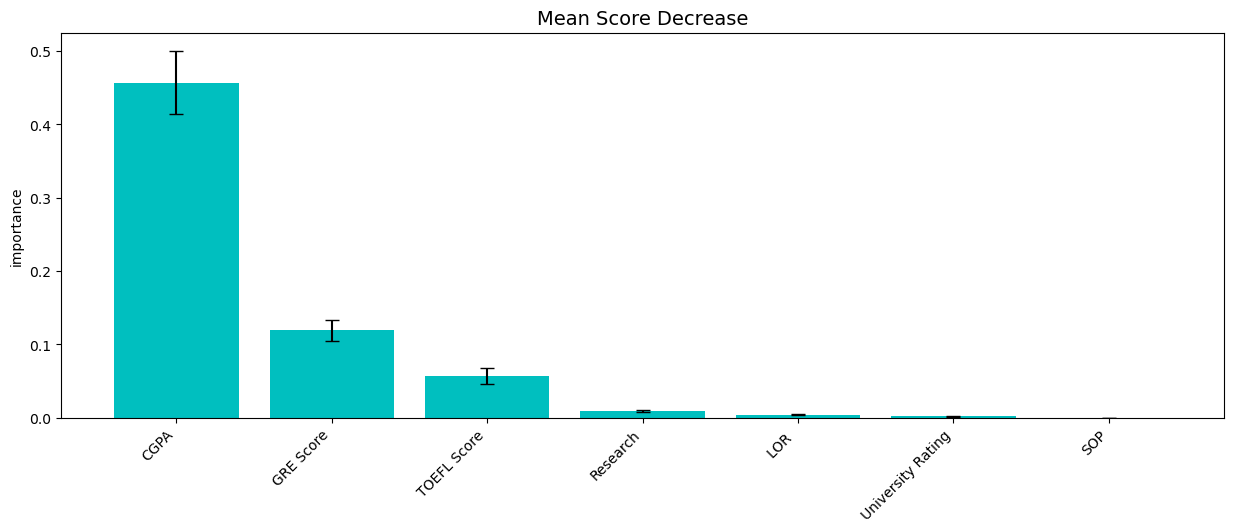

In [27]:
df_imp = mean_score_decrease(X_train, y_train, model, plot=True)

In [30]:
preprocessor = ColumnTransformer([
    ('numeric', num_pipe(), ["GRE Score", "TOEFL Score", "CGPA"]),
    ('categoric', cat_pipe(encoder='onehot'), ["Research", "LOR "]),
])

pipeline = Pipeline([
    ('prep', preprocessor),
    ('algo', ElasticNet())
])

model = RandomizedSearchCV(pipeline, rsp.enet_params, cv=3, n_iter=100, n_jobs=-1, verbose=1, random_state=42)
model.fit(X_train, y_train)

print(model.best_params_)
print(model.score(X_train, y_train), model.best_score_, model.score(X_test, y_test))

Fitting 3 folds for each of 100 candidates, totalling 300 fits
{'algo__alpha': 0.0016533597028439554, 'algo__fit_intercept': True, 'algo__l1_ratio': 0.076979909828793}
0.8222570006364411 0.8076162620134458 0.8096887608929507


# Phase 3: Polynomial

In [34]:
preprocessor = ColumnTransformer([
    ('numeric', num_pipe(poly=2, transform="yeo-johnson"), ["GRE Score", "TOEFL Score", "CGPA"]),
    ('categoric', cat_pipe(encoder='onehot'), ["Research", "LOR "]),
])

pipeline = Pipeline([
    ('prep', preprocessor),
    ('algo', ElasticNet())
])

model = RandomizedSearchCV(pipeline, rsp.enet_poly_params, cv=3, n_iter=100, n_jobs=-1, verbose=1, random_state=42)
model.fit(X_train, y_train)

print(model.best_params_)
print(model.score(X_train, y_train), model.best_score_, model.score(X_test, y_test))

Fitting 3 folds for each of 100 candidates, totalling 300 fits
{'algo__alpha': 0.0002781428564375755, 'algo__fit_intercept': True, 'algo__l1_ratio': 0.6510770255019446, 'prep__numeric__poly__degree': 3, 'prep__numeric__poly__interaction_only': True}
0.8225023999714312 0.8072548893108249 0.8107135541310749


C:\Users\ASUS\miniconda3\envs\jcop\Lib\site-packages\sklearn\linear_model\_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.894e-03, tolerance: 7.884e-04
  model = cd_fast.enet_coordinate_descent(


# Evaluation

In [32]:
from jcopml.plot import plot_residual

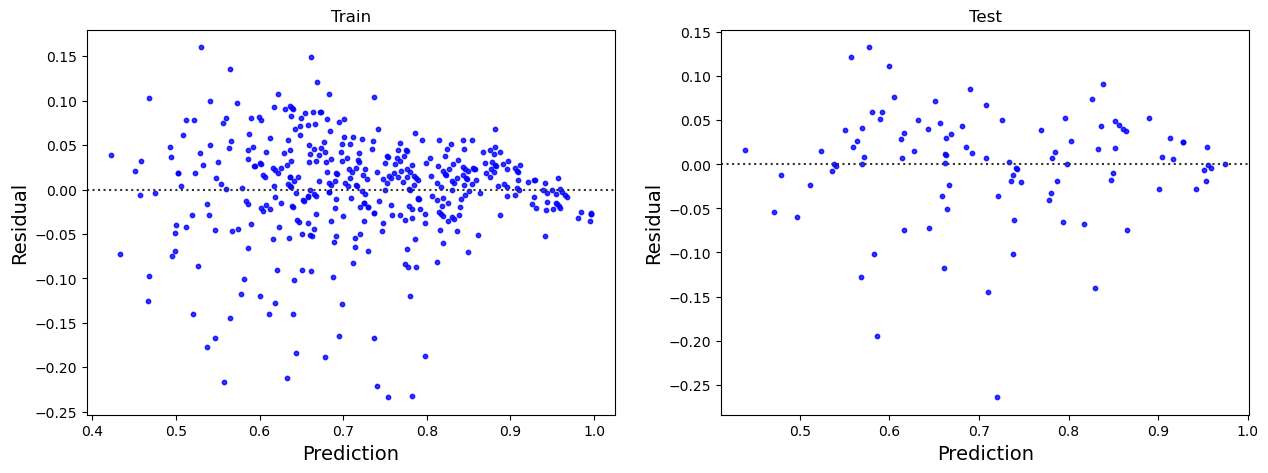

In [35]:
plot_residual(X_train, y_train, X_test, y_test, model)

In [36]:
df_analysis = X_train.copy()

pred = model.predict(X_train)
error = np.abs(pred - y_train)

df_analysis['chance'] = y_train
df_analysis['error'] = error
df_analysis.sort_values("error", ascending=False).head(10)

,GRE Score,TOEFL Score,University Rating,SOP,LOR,CGPA,Research,chance,error
Serial No.,,,,,,,,,
65,325,111,3,3.0,3.5,8.70,0,0.52,0.233568
66,325,112,4,3.5,3.5,8.92,0,0.55,0.232569
11,325,106,3,3.5,4.0,8.40,1,0.52,0.220513
93,298,98,2,4.0,3.0,8.03,0,0.34,0.217468
60,311,104,2,2.0,2.0,8.30,0,0.42,0.212234
42,316,105,2,2.5,2.5,8.20,1,0.49,0.188186
67,327,114,3,3.0,3.0,9.02,0,0.61,0.187567
41,308,110,3,3.5,3.0,8.00,1,0.46,0.184018
95,303,99,3,2.0,2.5,7.66,0,0.36,0.177352
